In [1]:
!pip install opendatasets --quiet

In [2]:
import opendatasets as od
import os
import torch
import torchvision.transforms as T
import torch.nn as nn
from torchvision import * 

In [3]:
dataset_url='https://www.kaggle.com/datasets/aakashns/jovian-pytorch-z2g?select=Human+protein+atlas'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rimoghosh
Your Kaggle Key: ··········


100%|██████████| 8.87G/8.87G [06:24<00:00, 24.8MB/s]


In [4]:
os.listdir('./jovian-pytorch-z2g')

['Human protein atlas', 'submission.csv']

In [5]:
data_dir='./jovian-pytorch-z2g/Human protein atlas'
train_dir=data_dir+'/train'
test_dir=data_dir+'/test'
print(len(os.listdir(train_dir)))
print(len(os.listdir(test_dir)))


19236
8243


In [6]:
import pandas as pd
df=pd.read_csv(data_dir+'/train.csv')
df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


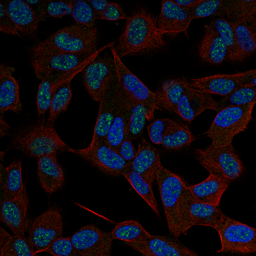

In [7]:
from PIL import Image
Image.open(train_dir+'/19567.png').resize((256,256))

In [8]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [9]:
def encode_label(label):
  target=torch.zeros(10)
  for l in str(label).split(' '):
    target[int(l)]=1
  return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

[Datsets and DataLoaders in PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [10]:
from torch.utils.data import Dataset, DataLoader
class HumanProteinDataset(Dataset):
  def __init__(self,df,img_dir,transform=None):
    self.df=df
    self.img_dir=img_dir
    self.transform=transform
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.loc[idx]
    img_id,label_id=row['Image'],row['Label']
    img_path=self.img_dir+"/"+ str(img_id)+".png"
    img=Image.open(img_path)
    if self.transform:
      img=self.transform(img)
    return img , encode_label(label_id)

__getitem__

The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

# ***Data Augmentation***

In [11]:
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
image_size=256
train_tfms=T.Compose([
    T.Resize(image_size),
    T.RandomCrop(image_size,padding=2,padding_mode='reflect'),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ToTensor()
    # T.Normalize(*stats,inplace=True)
])
val_tfms=T.Compose([
    T.Resize(image_size),
    T.ToTensor(),
    # T.Normalize(*stats,inplace=True)
])
test_tfms=T.Compose([
    T.Resize(image_size),
    T.ToTensor(),
    # T.Normalize(*stats,inplace=True)
])

In [12]:
import numpy as np
np.random.seed(42)
msk = np.random.rand(len(df)) < 0.9

train_df = df[msk].reset_index()
val_df = df[~msk].reset_index()

In [13]:
len(msk),len(~msk)

(19236, 19236)

In [14]:
train_ds=HumanProteinDataset(train_df,train_dir,transform=train_tfms)
val_ds=HumanProteinDataset(val_df,train_dir,transform=val_tfms)

In [15]:
len(train_ds),len(val_ds)

(17335, 1901)

In [16]:
import matplotlib.pyplot as plt
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1-img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: Nuclear speckles(9)


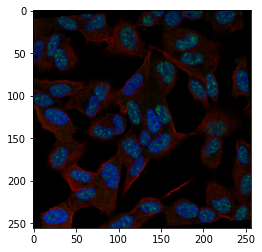

In [17]:
show_sample(*train_ds[0],False)

In [18]:
image,label=train_ds[0]
decode_target(label,True)

'Nuclear speckles(9)'

Labels: Nucleoplasm(4) Cytosol(6)


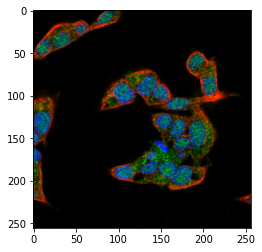

In [19]:
show_sample(*val_ds[0],False)

# **DataLoader**

In [20]:
batch_size=64

In [21]:
train_dl=DataLoader(train_ds,batch_size*2,num_workers=2,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size*2,num_workers=2,pin_memory=True)

In [22]:
from torchvision.utils import make_grid
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

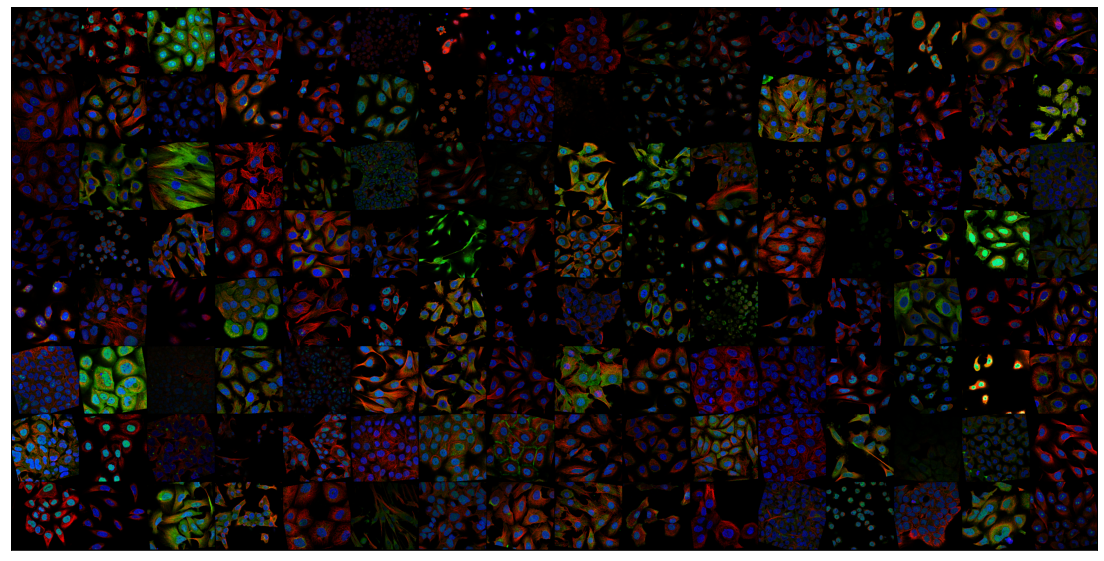

In [23]:
show_batch(train_dl,invert=False)

In [24]:
import torchvision.models as models
import torch.nn.functional as F

In [25]:
from sklearn.metrics import f1_score 

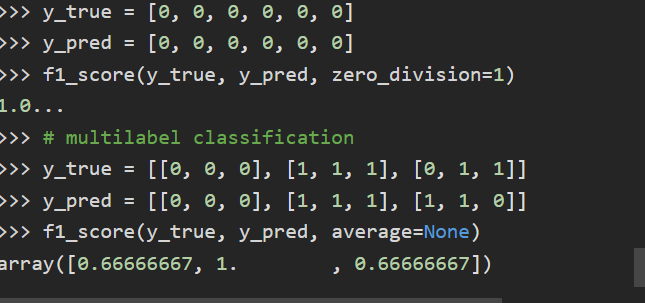

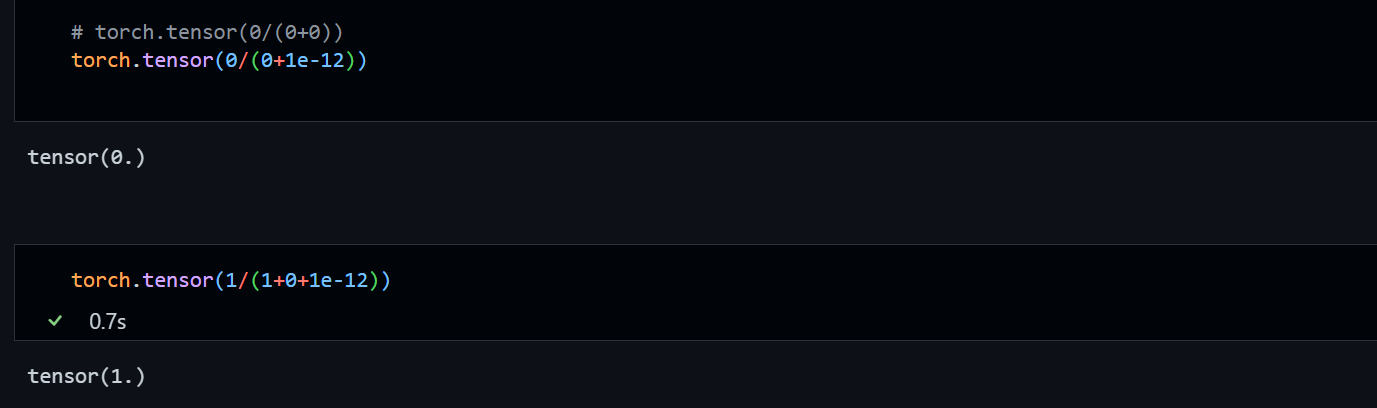

In [26]:
def f_score(labels,targets,threshold=0.5):
  labels= labels>threshold
  targets= targets > threshold
  
  TP=(labels & targets).sum(1).float()
  FP= (labels & (~targets)).sum(1).float()
  TN=((~labels) & (~targets)).sum(1).float()
  FN= ((~labels) & targets).sum(1).float()
  
  precision= torch.mean(TP/(TP + FP + 1e-10))
  recall= torch.mean(TP/(TP + FN + 1e-10))
  f1_score= 2*(precision*recall)/(precision + recall+1e-10)
  return f1_score.mean(0)

In [27]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = f_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [28]:
resnet34=models.resnet34(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [29]:
resnet34.fc=nn.Sequential(
    nn.Flatten(),
    nn.Linear(resnet34.fc.in_features,128),
    nn.Linear(128,10)
)

In [30]:
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
class ProteinResnet(MultilabelImageClassificationBase):
    def __init__(self,resnet34):
        super().__init__()
        self.resnet34=resnet34
        
    def forward(self, xb):
        return torch.sigmoid(self.resnet34(xb))

In [32]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [33]:
device=get_default_device()
device

device(type='cuda')

In [34]:
train_dl=DeviceDataLoader(train_dl,device=device)
val_dl=DeviceDataLoader(val_dl,device=device)
len(train_dl)

136

In [35]:
model=to_device(ProteinResnet(resnet34),device)
model

ProteinResnet(
  (resnet34): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

# **Training**

In [36]:
from tqdm.notebook import tqdm

In [37]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
history=[evaluate(model,val_dl)]

In [39]:
history

[{'val_loss': 0.687089741230011, 'val_score': 0.2707299292087555}]

In [40]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [41]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0028, train_loss: 0.3045, val_loss: 0.4108, val_score: 0.3108


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0076, train_loss: 0.2934, val_loss: 0.4454, val_score: 0.3132


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0100, train_loss: 0.2914, val_loss: 0.3644, val_score: 0.3538


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0095, train_loss: 0.2802, val_loss: 0.4005, val_score: 0.4367


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0081, train_loss: 0.2694, val_loss: 0.3243, val_score: 0.4848


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0061, train_loss: 0.2596, val_loss: 0.3114, val_score: 0.4738


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0039, train_loss: 0.2475, val_loss: 0.3052, val_score: 0.5105


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0019, train_loss: 0.2363, val_loss: 0.2358, val_score: 0.6240


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0005, train_loss: 0.2227, val_loss: 0.2188, val_score: 0.6641


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0000, train_loss: 0.2130, val_loss: 0.2148, val_score: 0.6790
CPU times: user 6min 21s, sys: 5min 54s, total: 12min 15s
Wall time: 34min 12s


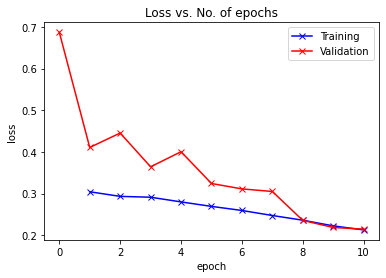

In [43]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
plot_losses(history)

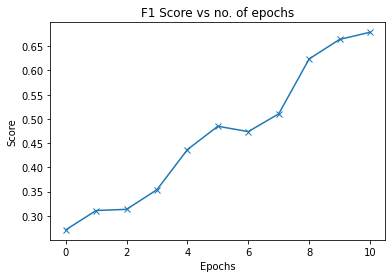

In [44]:
def plot_accuracy(history):
  plt.plot([x['val_score'] for x in history],'-x')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.title('F1 Score vs no. of epochs')
  plt.show()

plot_accuracy(history)

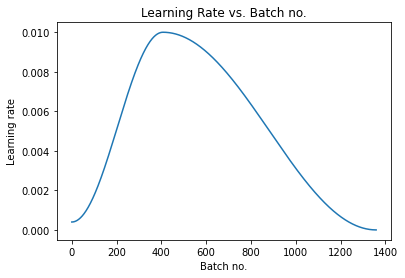

In [45]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

# **Testing**

In [63]:
test_df=pd.read_csv('./jovian-pytorch-z2g/submission.csv')
test_dir=data_dir+'/test'
test_df.sample(10)

,Image,Label
4260,12648,0
7007,18983,0
4733,22044,0
3608,28812,0
7242,19917,0
632,23434,0
7829,16960,0
4982,23281,0
5165,21497,0
5652,18270,0


In [47]:
test_ds=HumanProteinDataset(test_df,test_dir,transform=test_tfms)
test_dl=DataLoader(test_ds,batch_size*2,num_workers=2,pin_memory=True)
test_dl=DeviceDataLoader(test_dl,device=device)

Labels: Mitochondria(0)


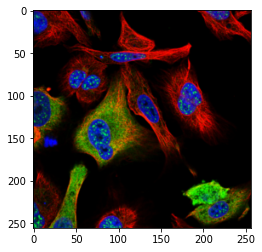

In [64]:
show_sample(*test_ds[10],False)

In [80]:
def predict_image(image):
  xb=image.unsqueeze(0)
  xb=to_device(xb,device)
  out=model(xb)
  preds=out[0]
  show_sample(image,preds,False)

Labels: Nuclear speckles(9)
Target: Mitochondria(0)


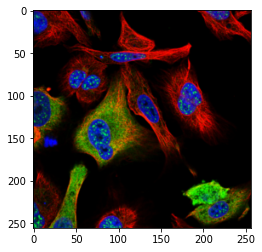

In [85]:
image,target1=test_ds[10]
predict_image(image)
print('Target:',decode_target(target1,True))

Labels: Nucleoplasm(4)
Target: Mitochondria(0)


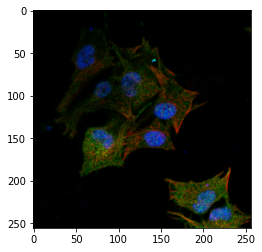

In [89]:
image,target1=test_ds[1091]
predict_image(image)
print('Target:',decode_target(target1,True))

Labels: Nucleoplasm(4)
Target: Mitochondria(0)


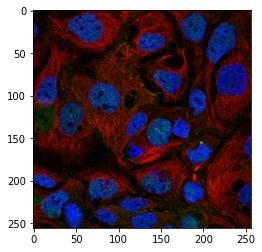

In [90]:
image,target1=test_ds[1947]
predict_image(image)
print('Target:',decode_target(target1,True))

Labels: Mitochondria(0) Cytosol(6)
Target: Mitochondria(0)


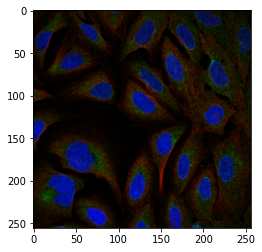

In [99]:
image,target1=test_ds[2524]
predict_image(image)
print('Target:',decode_target(target1,True))